# Question 1

1. *[15 marks] Obtain the code and dataset (under Topic 1 on Learn Ultra) and load the ``citation_graph``.  Two vertices $u$ and $v$ are connected in this graph if there is a path from $u$ to $v$ or from $v$ to $u$ (or both).  A connected component of the graph is a maximal set of vertices such that each pair of vertices is connected.  How many vertices are there in the largest connected component of the ``citation_graph``?  Let $G$ be the graph formed by the largest connected component of the ``citation_graph`` (that is, obtain $G$ by removing all vertices not in the largest connected component).  Create two plots showing the normalized distributions of the in-degree and out-degree of $G$.*

First we import some packages to write our code.

In [1]:
from typing import Dict
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random
import numpy as np


def print_status_bar(progress: float, block_count: int = 10) -> None:
    clear_output(wait=True)
    dark_string = "▓" * round(progress * block_count)
    light_string = "░" * (block_count - len(dark_string))
    print(f"[{dark_string}{light_string}]")

Following is similar code to the code provided for calculating degree distributions and loading graphs.

In [2]:
def compute_in_degrees(g: Dict[int, list[int]]) -> Dict[int, int]:
    i_degs = {}
    for v in g:
        i_degs[v] = 0
    for v in g:
        for nghbr in g[v]:
            if nghbr not in i_degs:
                continue
            i_degs[nghbr] += 1
    return i_degs


def compute_out_degrees(g: Dict[int, list[int]]) -> Dict[int, int]:
    o_degs = {}
    for v in g:
        o_degs[v] = len(g[v])
    return o_degs


def in_degree_freq_dist(g: Dict[int, list[int]]) -> Dict[int, int]:
    i_degs = compute_in_degrees(g)
    freq_dist = {}
    for v in i_degs:
        if i_degs[v] in freq_dist:
            freq_dist[i_degs[v]] += 1
        else:
            freq_dist[i_degs[v]] = 1
    return freq_dist


def out_degree_freq_dist(g: Dict[int, list[int]]) -> Dict[int, int]:
    o_degs = compute_out_degrees(g)
    freq_dist = {}
    for v in o_degs:
        if o_degs[v] in freq_dist:
            freq_dist[o_degs[v]] += 1
        else:
            freq_dist[o_degs[v]] = 1
    return freq_dist


def load_graph(raw: str) -> Dict[int, list[int]]:
    g = open(raw)
    ag = {}
    ns = 0
    for l in g:
        nghbrs = l.split(' ')
        n = int(nghbrs[0])
        ag[n] = set([])
        for nghbr in nghbrs[1: -1]:
            ag[n].add(int(nghbr))
        ns += 1
    print("Loaded graph with", ns, "nodes")
    return ag

We then load the citation graph.

In [3]:
citation_graph = load_graph("alg_phys-cite.txt")

Loaded graph with 27770 nodes


We then undirect the graph.

In [4]:
def undirect(g: Dict[int, list[int]]) -> Dict[int, list[int]]:
    und_g = {}
    for v in g:
        und_g[v] = set(g[v].copy())
    for v in g:
        for nghbr in g[v]:
            und_g[nghbr].add(v)
    for v in g:
        und_g[v] = list(und_g[v])
    return und_g

In [5]:
un_citation_graph = undirect(citation_graph)
print(f"Citation graph undirected.")

Citation graph undirected.


Find below for finding the connected components of a graph, with a breadth-first search algorithm which it uses.

In [6]:
def bfs(g: Dict[int, list[int]], node: int) -> list[int]:
    vstd = set([node])
    q = [node]
    while q:
        v = q.pop(0)
        for nghbr in g[v]:
            if nghbr not in vstd:
                vstd.add(nghbr)
                q.append(nghbr)
    return list(vstd)


def get_ccs(g: Dict[int, list[int]]) -> list[list[int]]:
    ccs = []
    vs = set(list(g.keys()))
    while vs:
        clear_output(wait=True)
        print(f"Current number of components: {len(ccs)}")
        print(f"Unvisited nodes remaining: {len(vs)}")
        b = bfs(g, vs.pop())
        ccs.append(b.copy())
        vs = vs.difference(b)
    return ccs

We then run this code on our citation graph.

In [7]:
ccs = get_ccs(un_citation_graph)
max_cc = max(ccs, key=lambda k: len(k))
clear_output(wait=True)
print(
    f"Found {len(ccs)} connected components, with largest having {len(max_cc)} nodes.")

Found 143 connected components, with largest having 27400 nodes.


Find below some code for calculating the induced graph from a vertex set (used to find the subgraph of the largest connected component).

In [8]:
def get_ind_graph_from_cc(ig: Dict[int, list[int]], v_set: list[int]) -> Dict[int, list[int]]:
    g = {}
    for v in v_set:
        g[v] = ig[v]
    return g

We then run this on our citation graph and the vertex set of the largest connected component.

In [9]:
ind_max_cc = get_ind_graph_from_cc(citation_graph, max_cc)

We find below auxiliary code for plotitng.

In [10]:
def loglog_plot(xdata, ydata, title, xlabel, color="blue"):
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.xlabel(xlabel)
    plt.ylabel("Normalized Rate")
    plt.title(title)
    plt.loglog(xdata, ydata, marker=".", linestyle="None", color=color)
    plt.show()


def norm_freq_dist(freq_dist: Dict[int, int]) -> Dict[int, int]:
    n = 0
    for freq in freq_dist.values():
        n += freq
    norm_freq_dist = {}
    for cat in freq_dist:
        norm_freq_dist[cat] = freq_dist[cat] / n
    return norm_freq_dist


def freq_dist_to_array(freq_dist: Dict[int, int]) -> tuple[int, int]:
    xs, ys = [], []
    for cat in freq_dist:
        xs += [cat]
        ys += [freq_dist[cat]]
    return xs, ys


def graph_to_in_degree_plot(g: Dict[int, list[int]], color="blue",
                            title="In-Degree Distribution of Largest Connected Component") -> None:
    i_deg_freq_dist = in_degree_freq_dist(g)
    norm_i_deg_freq_dist = norm_freq_dist(i_deg_freq_dist)
    xs, ys = freq_dist_to_array(norm_i_deg_freq_dist)
    loglog_plot(xs, ys, title, "In-Degree", color=color)


def graph_to_out_degree_plot(g: Dict[int, list[int]], color="blue",
                             title="Out-Degree Distribution of Largest Connected Component") -> None:
    o_deg_freq_dist = out_degree_freq_dist(g)
    norm_o_deg_freq_dist = norm_freq_dist(o_deg_freq_dist)
    xs, ys = freq_dist_to_array(norm_o_deg_freq_dist)
    loglog_plot(xs, ys, title, "Out-Degree", color=color)


We now plot the two normalised distributions as requested.

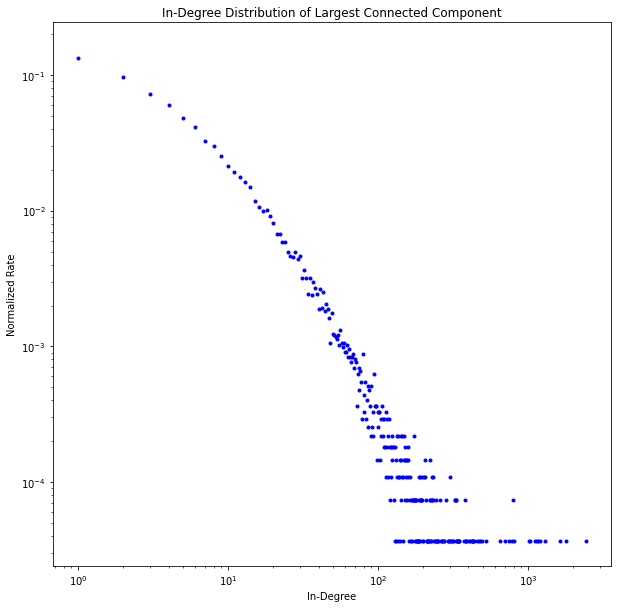

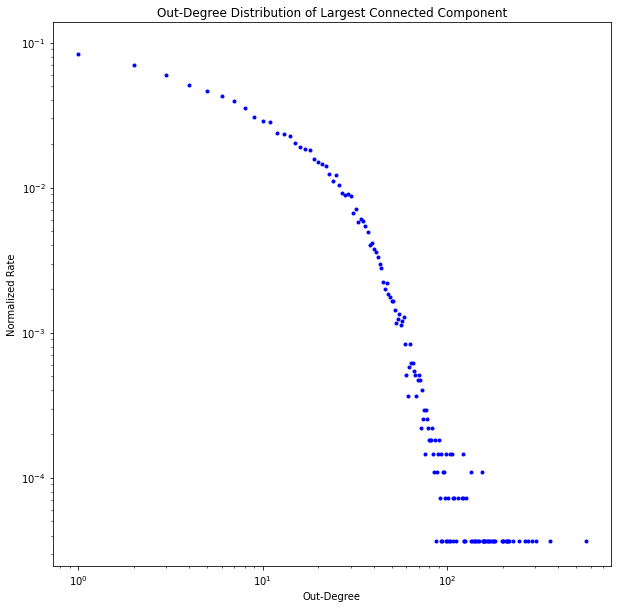

In [11]:
graph_to_in_degree_plot(ind_max_cc)
graph_to_out_degree_plot(ind_max_cc)

# Question 2
2. *[15 marks] Recall the PA graph model that constructed graphs one vertex at a time.  In this model the out-degrees were all (almost) the same.  Define a version of the model where the out-degree varies in a way that is similar to the distribution found for $G$ in Question 1.  Construct instances of the model and plot the normalized distributions of the in-degree and out-degree and compare them to those of $G$.  (Your model might turn out to be a poor model for $G$.  This does not matter as long as you can motivate your definition and implement it correctly.)*

Find below the code to generated the requested the PA model.

In [12]:
def generate_pa_network(n: int, m: int, scale_parameter: float) -> Dict[int, set[int]]:
    debug_period = (n - m) // 160

    ba_network = dict()
    out_degree_distribution = []

    for node in range(m):
        ba_network[node] = set()
        out_degree_distribution.append(node)
    for node in range(m, n):
        if node % debug_period == 0:
            print_status_bar((node / (n - m - 1)) ** 2, block_count=80)

        if len(out_degree_distribution) == 1:
            m_now = 1
        else:
            m_now = np.random.exponential(scale_parameter, 1)
            while m_now < 1 or m_now > len(out_degree_distribution):
                m_now = np.random.exponential(scale_parameter, 1)

        sample = random.sample(out_degree_distribution, random.randint(1, int(m_now)))

        ba_network[node] = set()

        for neighbour in sample:
            out_degree_distribution.append(node)
            ba_network[node].add(neighbour)

    return ba_network


We generate this model for some chosen parameters.

In [13]:
pa_networks = []
for m, scale_parameter in [(1, 15), (15, 1), (1, 1), (50, 50), (100, 100)]:
    pa_networks.append(generate_pa_network(len(citation_graph), m, scale_parameter))
clear_output(wait=True)
print(f"5 PA models generated.")

5 PA models generated.


And then we plot them.

In-degree distribution plots for the model


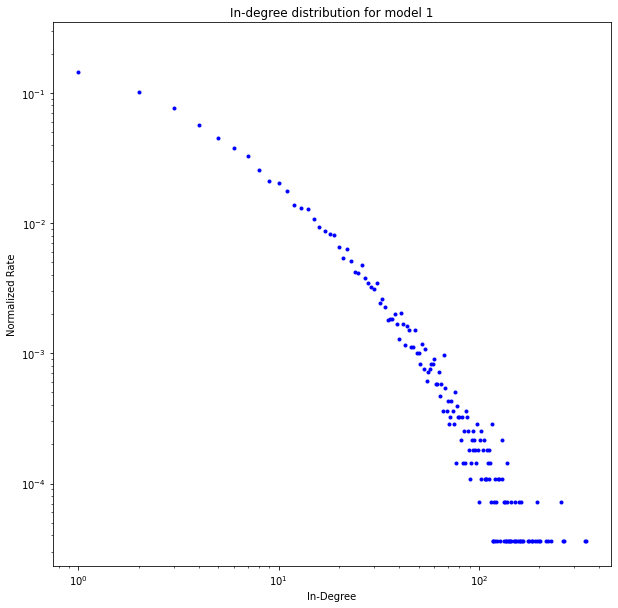

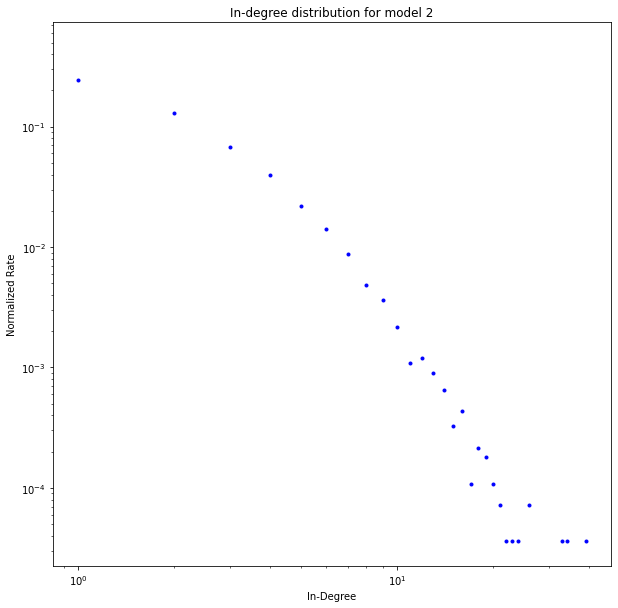

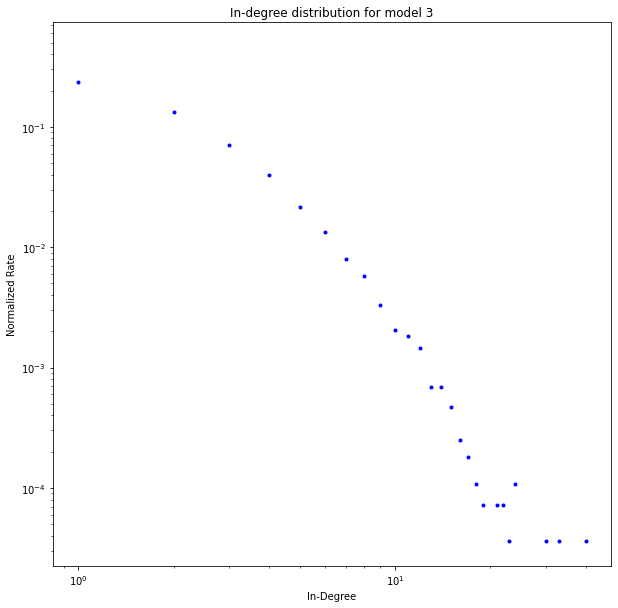

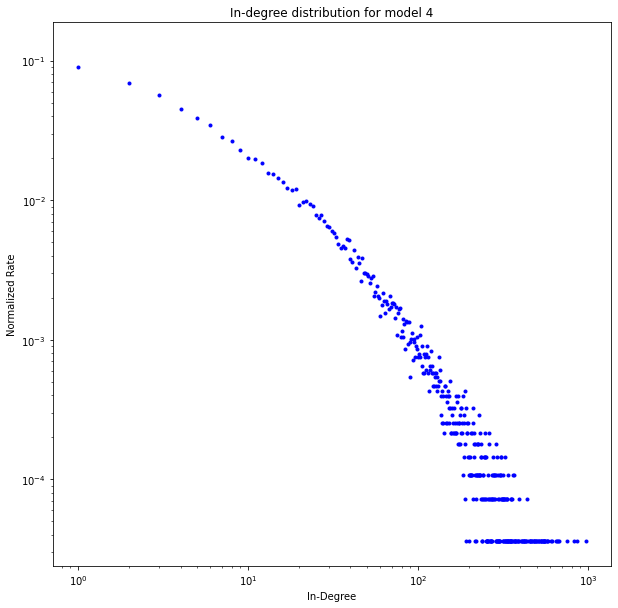

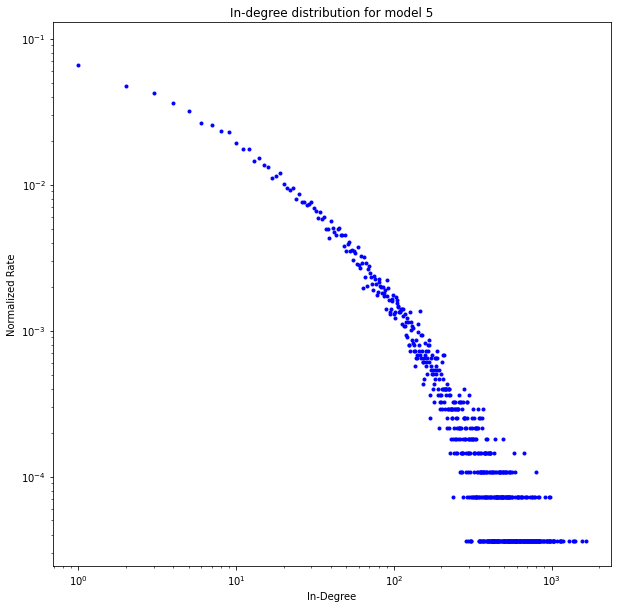

In [14]:
print("In-degree distribution plots for the model")
for i, pa_network in enumerate(pa_networks):
    graph_to_in_degree_plot(pa_network, title=f"In-degree distribution for model {i + 1}")

Out-degree distribution plots for the model


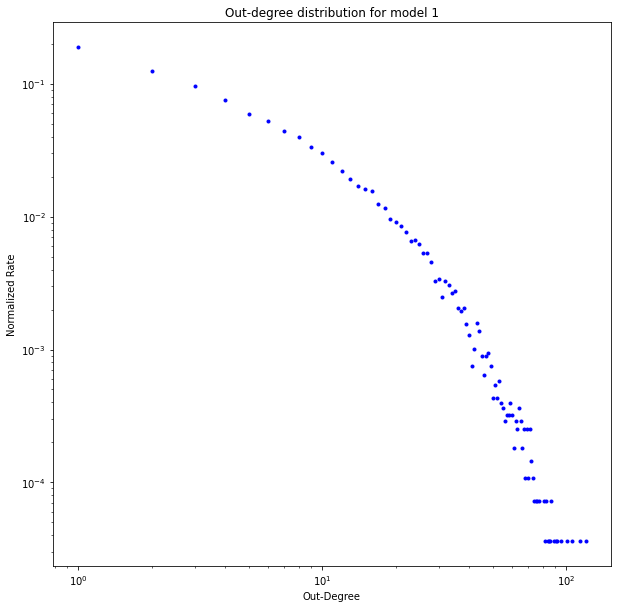

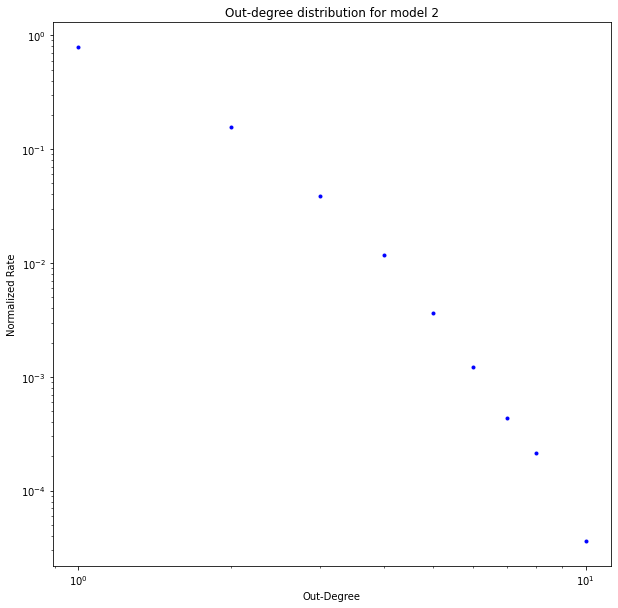

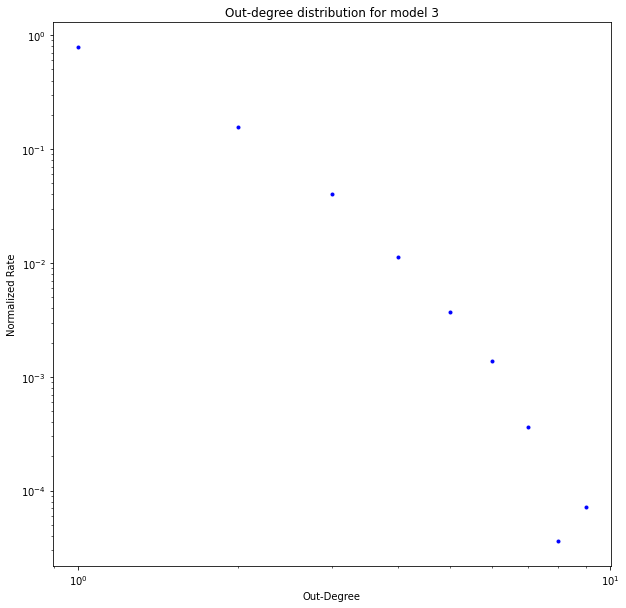

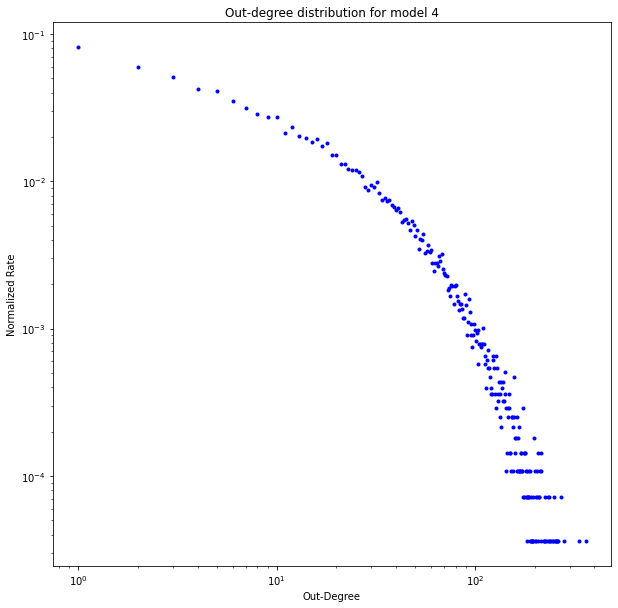

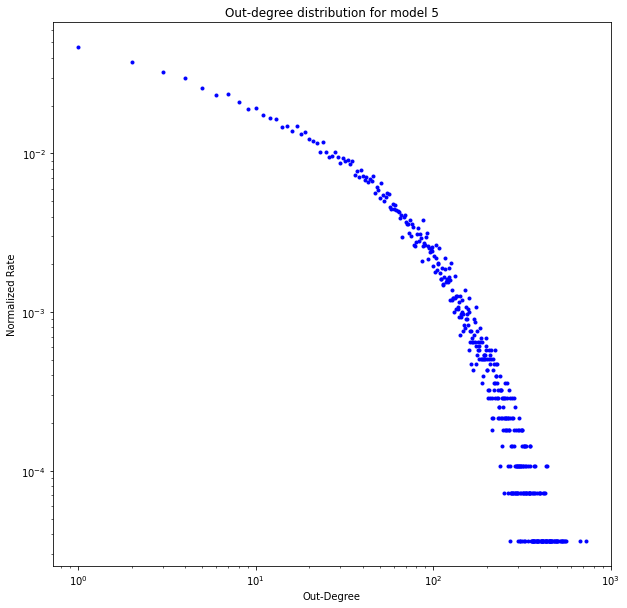

In [15]:
print("Out-degree distribution plots for the model")
for i, pa_network in enumerate(pa_networks):
    graph_to_out_degree_plot(pa_network, title=f"Out-degree distribution for model {i + 1}")

## Model motivation

We want a model's in-degree and out-degree distributions to match that of the largest connected component of the citation graph. We can characterise the citation graph's graph by the following principle (the *Matthew effect of accumulated advantage*): the rich get richer and the poor get poorer. Applying this to the citation, a paper is more likely to cite a well-cited paper, and as a result a paper that is not well-cited does not see many papers citing it. This does not completely motivate the following model description, particularly in respect to our out-degree distribution. It is noted that the out-degrees of the citation graph follows a similar structure to the in-degrees/

## Model description

The model above has three parameters:

* $n \in \mathbb N$: the number of node;
* $m \in \mathbb N$: the initial number of (isolated) nodes, we call this the *initial size*; and
* $\beta \in \mathbb R$: the scale parameter.

We now describe the graph generation process.

1. $m$ isolated nodes are generated.
2. We add $n$ new nodes. For each node added, we choose a uniform random sample (with replacement and weighted according to the out degrees of the nodes) of size $X$ of the other nodes in the network, where $X$ is the random variable of a zero-truncated exponential distribution with rate parameter $1/\beta$ (that is, $X \sim \operatorname{ZTExp}(1/\lambda)$). If our sample contains a duplicate vertices, we add only the edge once (as we want a simple graph).

## Model comparison

Above we varied the model with $n$ equal to the size of the citation graph, and the following parameters.

* (1) $m = 1$, $\beta = 15$;
* (2) $m = 15$, $\beta = 1$;
* (3) $m = \beta = 1$;
* (4) $m = \beta = 50$; and
* (5) $m = \beta = 100$.

We see that the in-degree distribution in model (1) closely matches that of the citation graph, while the other models are close fits. The out-degree distribution in model (1) has a similar profile to that of the citation graph, however not that the size of low out-degree nodes (the poor) is amplified, and conversely the size of high out-degree nodes (the rich) is abridged.

## Model justification

The body of our justification for this model comes in two slices: the weighting of the sample taken and the choice of random variable for the size of the sample.

A apt mention of preferential attachment adequately justifies the weighting of the sample: we want to connect to nodes based how much they cite, in order to obtain an in-degree distribution like that of the citation graph.

To justify the choice of random variable, we note that the out-degree will be determined uniquely by this variable. By truncating the exponential distribution and look at the log-log plot, we obtain an out-degree distribution similar to that of the citation graph.